In [ ]:
import itertools
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class MnistDataset():
    def __init__(self, X, y, transform_X=lambda x: x):
        assert X.shape[0] == y.shape[0]
        self.X = transform_X(X)
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def load_mnist(path):
    with open(path, 'rb') as f:
        train_data, test_data = pickle.load(f)

    X_train = torch.tensor(train_data[0], dtype=torch.float).unsqueeze(1)
    y_train = torch.tensor(train_data[1], dtype=torch.long)
    X_test = torch.tensor(test_data[0], dtype=torch.float).unsqueeze(1)
    y_test = torch.tensor(test_data[1], dtype=torch.long)
    return X_train, y_train, X_test, y_test

In [ ]:
path = '/content/mnist.pkl'
X_train, y_train, X_test, y_test = load_mnist(path)
X_train = X_train / torch.max(X_train)
X_test = X_test / torch.max(X_test)
print(X_train[0].shape)

torch.Size([1, 32, 32])


In [ ]:
train_index, val_index = train_test_split(range(len(X_train)), test_size=0.2, random_state=0)
train_data = MnistDataset(X_train[train_index], y_train[train_index])
val_data = MnistDataset(X_train[val_index], y_train[val_index])
test_data = MnistDataset(X_test, y_test)

In [ ]:
class VAE(nn.Module):
    def __init__(self, in_channels=1, z_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        dim_after_conv = 2
        hidden_dim = 32 * dim_after_conv * dim_after_conv
        self.readout_mu = nn.Linear(hidden_dim, z_dim)
        self.readout_sigma = nn.Linear(hidden_dim, z_dim)
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.Unflatten(1, (32, dim_after_conv, dim_after_conv)),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, sigma):
        epsilon = torch.randn(1)
        z = mu + epsilon * sigma
        return z

    def encode(self, x):
        h = self.encoder(x)
        mu = self.readout_mu(h)
        sigma = self.readout_sigma(h)
        return mu, sigma

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, sigma = self.encode(x)
        z = self.reparameterize(mu, sigma)
        x_recon = self.decode(z)
        return x_recon, mu, sigma

In [ ]:
def kld_loss_func(mu, sigma):
    return 0.5 * torch.sum(mu**2 + sigma**2 - torch.log(sigma**2) - 1)


def vae_loss_func(recon_x, x, mu, sigma):
    bce_loss = nn.BCELoss(reduction='sum')(recon_x, x)
    kld_loss = kld_loss_func(mu, sigma)
    return bce_loss + kld_loss

tensor(1.3863)


In [ ]:
class VAETrainer:

    def __init__(self, model, learning_rate, batch_size, epoch, l2):
        self.model = model
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")

        self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)

        self.epoch = epoch
        self.batch_size = batch_size

    def train(self, train_data, val_data, early_stop=True, verbose=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)

        train_loss_list = []
        val_loss_list = []

        weights = self.model.state_dict()
        lowest_val_loss = np.inf

        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            epoch_loss = 0.0
            for X_batch, y_batch in train_loader:
                batch_importance = 1 / len(train_data)
                X_batch_recon, mu, sigma = self.model(X_batch)
                batch_loss = vae_loss_func(X_batch_recon, X_batch, mu, sigma)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                epoch_loss += batch_loss.detach().cpu().item() * batch_importance

            train_loss_list.append(epoch_loss)

            val_loss = self.evaluate(val_data, print_loss=False)
            val_loss_list.append(val_loss)

            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(x_axis, train_loss_list, label="Train")
            ax.plot(x_axis, val_loss_list, label="Validation")
            ax.set_title("Total Loss")
            ax.set_xlabel("# Epoch")

        if early_stop:
            self.model.load_state_dict(weights)

        return {
            "train_loss_list": train_loss_list,
            "val_loss_list": val_loss_list,
        }

    def evaluate(self, data, print_loss=True):
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size)
        total_loss = 0.0
        for X_batch, y_batch in loader:
            with torch.no_grad():
                batch_importance = 1 / len(data)
                X_batch_recon, mu, sigma = self.model(X_batch)
                batch_loss = vae_loss_func(X_batch_recon, X_batch, mu, sigma)
                total_loss += batch_loss.detach().cpu().item() * batch_importance
        if print_loss:
            print(f"Total Loss: {total_loss}")
        return total_loss

VAE - Number of parameters: 34201


{'train_loss_list': [204.5221366373698,
  151.6815785420738,
  133.57699249776203,
  110.51258705647786,
  103.12208149719224,
  94.17065293375659,
  90.8026099141439,
  86.83988002522794,
  84.7516860860187,
  84.1839515482586,
  82.56974624633803,
  80.62528989664733,
  80.60444621276847,
  80.05406934865304,
  82.91329536437985,
  78.02364450327569,
  77.4835834986369,
  77.73889186859121,
  75.83274069976785,
  75.82428737894705,
  75.98905401357021,
  75.37328118387858,
  74.86107660675064,
  73.81216514841725,
  74.50696374003101,
  72.48937160237628,
  74.45675656636554,
  72.42217862955724,
  71.73166099548331,
  72.28370025634759],
 'val_loss_list': [158.66239326985664,
  139.04076527913406,
  120.13822798665367,
  106.63562103271487,
  93.88144368489584,
  89.62162876383472,
  115.59563920084628,
  84.15289880371093,
  80.8810370076497,
  92.2178947347005,
  78.65962988281247,
  83.84537166341151,
  79.48840474446614,
  76.53411187744142,
  91.84715865071614,
  76.49590777587

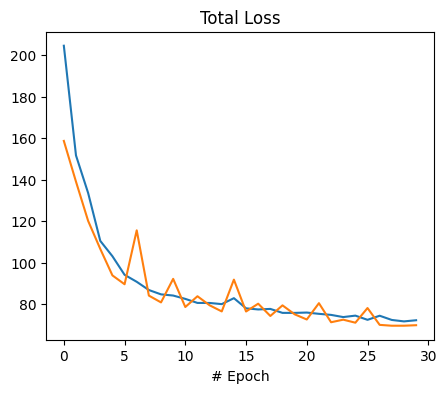

In [ ]:
vae = VAE()
trainer = VAETrainer(vae, 1e-3, 32, 30, 1e-5)
trainer.train(train_data, val_data)

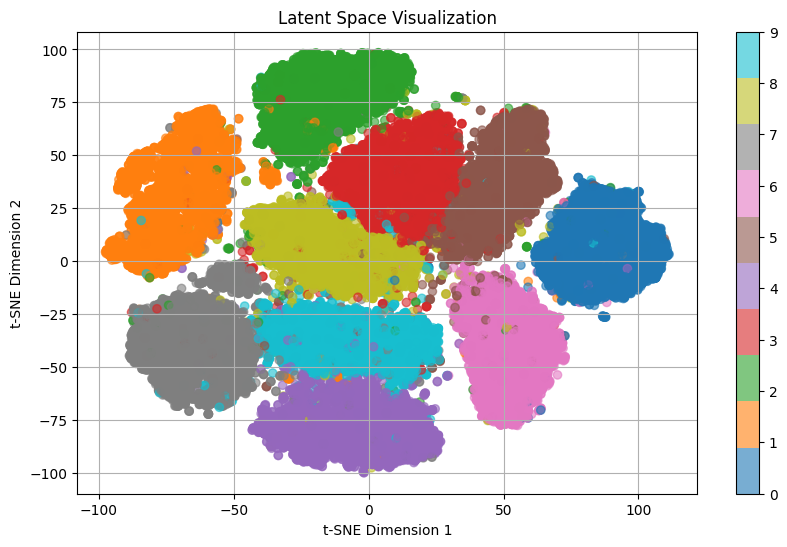

In [ ]:
def visualize_latent_space(vae, data_loader):
    vae.eval()
    latents, labels = [], []
    with torch.no_grad():
        for x, y in data_loader:
            mean, _ = vae.encode(x)
            latents.append(mean)
            labels.append(y)

    latents = torch.cat(latents).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(latents)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('Latent Space Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.show()

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
visualize_latent_space(vae, train_loader)

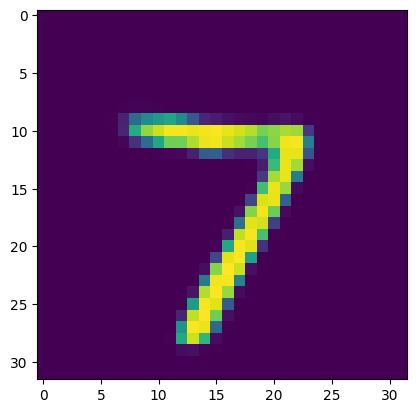

In [ ]:
plt.imshow(X_recon[0].reshape(32, 32).detach().numpy())
plt.show()

In [ ]:
np.save("conv_vae_images.npy", X_recon_resized.detach().numpy())

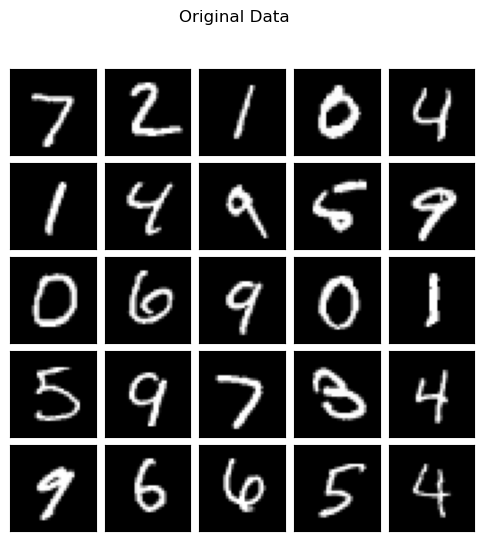

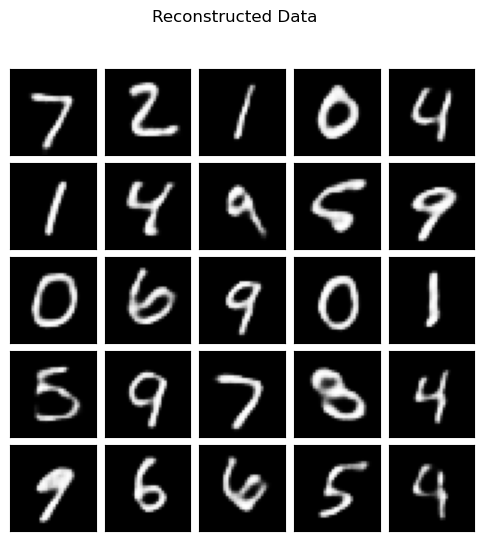

In [ ]:
def plot_digits(data, title):
    fig, axes = plt.subplots(5, 5, figsize=(6, 6))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.suptitle(title)
    for i, ax in enumerate(axes.flatten()):
        im = ax.imshow(data[i].reshape(32, 32), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

def compare_reconstruct(model, X):
    plot_digits(X, "Original Data")
    with torch.no_grad():
        X_recon, _, _ = model(X)
    plot_digits(X_recon, "Reconstructed Data")


compare_reconstruct(trainer.model, X_test[:100])